<div align="center">

  <a href="https://ultralytics.com/yolo" target="_blank">
    <img width="1024", src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png"></a>

  [中文](https://docs.ultralytics.com/zh/) | [한국어](https://docs.ultralytics.com/ko/) | [日本語](https://docs.ultralytics.com/ja/) | [Русский](https://docs.ultralytics.com/ru/) | [Deutsch](https://docs.ultralytics.com/de/) | [Français](https://docs.ultralytics.com/fr/) | [Español](https://docs.ultralytics.com/es/) | [Português](https://docs.ultralytics.com/pt/) | [Türkçe](https://docs.ultralytics.com/tr/) | [Tiếng Việt](https://docs.ultralytics.com/vi/) | [العربية](https://docs.ultralytics.com/ar/)

  <a href="https://github.com/ultralytics/ultralytics/actions/workflows/ci.yml"><img src="https://github.com/ultralytics/ultralytics/actions/workflows/ci.yml/badge.svg" alt="Ultralytics CI"></a>
  <a href="https://colab.research.google.com/github/ultralytics/notebooks/blob/main/notebooks/how-to-use-ultralytics-yolo-with-openai-for-number-plate-recognition.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
  
  <a href="https://ultralytics.com/discord"><img alt="Discord" src="https://img.shields.io/discord/1089800235347353640?logo=discord&logoColor=white&label=Discord&color=blue"></a>
  <a href="https://community.ultralytics.com"><img alt="Ultralytics Forums" src="https://img.shields.io/discourse/users?server=https%3A%2F%2Fcommunity.ultralytics.com&logo=discourse&label=Forums&color=blue"></a>
  <a href="https://reddit.com/r/ultralytics"><img alt="Ultralytics Reddit" src="https://img.shields.io/reddit/subreddit-subscribers/ultralytics?style=flat&logo=reddit&logoColor=white&label=Reddit&color=blue"></a>
  
  Welcome to the ANPR with Ultralytics YOLO26 notebook! <a href="https://github.com/ultralytics/ultralytics">YOLO26</a> is the latest version of the YOLO (You Only Look Once) AI models developed by <a href="https://ultralytics.com">Ultralytics</a>. We hope that the resources in this notebook will help you get the most out of YOLO26. Please browse the YOLO26 <a href="https://docs.ultralytics.com/">Docs</a> for details, raise an issue on <a href="https://github.com/ultralytics/ultralytics">GitHub</a> for support, and join our <a href="https://ultralytics.com/discord">Discord</a> community for questions and discussions!</div>

# Automatic Number Plate Recognition using Ultralytics YOLO26 + OpenAI `gpt-4o-mini`

This notebook provides a comprehensive guide to implementing automatic number plate recognition (ANPR) using the YOLO26 model in combination with `gpt-4o-mini`.

## What is Automatic Number Plate Recognition (ANPR)?
Automatic number plate recognition is a technology designed to identify and extract vehicle number plate information from images or videos. By leveraging the powerful capabilities of Ultralytics YOLO26 for object detection and OpenAI `gpt-4o-mini` for text recognition, ANPR becomes an efficient solution for automating vehicle identification tasks.

## Why Use YOLO26 + GPT-4o-Mini for ANPR?

- Accurate Detection: YOLO26’s object detection capabilities ensure precise localization of license plates in various conditions, such as low light or high-speed movement.

- Seamless Text Recognition: With `gpt-4o-mini`, extracted license plate regions are processed to recognize alphanumeric text accurately, even with variations in font, angle, or clarity.

- Real-Time Processing: The integration allows for real-time vehicle monitoring, making it ideal for applications in traffic management, parking systems, and security surveillance.🚗

### Setup

pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

[![PyPI - Version](https://img.shields.io/pypi/v/ultralytics?logo=pypi&logoColor=white)](https://pypi.org/project/ultralytics/) [![Downloads](https://static.pepy.tech/badge/ultralytics)](https://clickpy.clickhouse.com/dashboard/ultralytics) [![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

In [ ]:
!uv pip install ultralytics

import base64

import cv2
import ultralytics
from ultralytics import YOLO
from ultralytics.utils.downloads import safe_download
from ultralytics.utils.plotting import Annotator, colors

ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.8/112.6 GB disk)


In [4]:

# download the sample model file
safe_download("https://github.com/ultralytics/assets/releases/download/v0.0.0/anpr-demo-model.pt")

PosixPath('anpr-demo-model.pt')

In [5]:
# Load the Ultralytics YOLO license plate detection model
model = YOLO("anpr-demo-model.pt")

### Process Single Image Frame

### Configure Gemini Client

It’s time to configure the OpenAI client that will accept `base64` image data, extract the number plate text, and return it as a response. The configuration allows you to adjust the content sent to the OpenAI model, and you can also choose different models, such as `gpt-4o`.

The `extract_text` function is designed to process a base64-encoded image containing a vehicle's number plate.


✅ If the text cannot be extracted, the function ensures a response of None. -

✅ Additionally, it filters out any text written near the license plate to provide accurate results.

In [31]:
import google.generativeai as genai
from PIL import Image
import io
from google.colab import userdata

# Avoid hardcoding credentials directly in your script.
google_gemini_api_key = userdata.get('google_gemini_api_key')

# Configure Gemini API
genai.configure(api_key=google_gemini_api_key)
gemini_model = genai.GenerativeModel('gemini-2.5-flash')

# Define the text prompt
prompt = """
Can you extract the vehicle number plate text inside the image?
If you are not able to extract text, please respond with None.
Only output text, please.
If any text character is not from the English language, replace it with a dot (.)
"""

def extract_text(base64_encoded_data):
    try:
        # Decode base64 image data
        image_bytes = base64.b64decode(base64_encoded_data)
        img = Image.open(io.BytesIO(image_bytes))

        # Create the content list for Gemini API
        content = [
            prompt,
            img
        ]

        # Generate content using Gemini model
        response = gemini_model.generate_content(content)

        # Extract text from the response
        extracted_text = response.text.strip()

        # Check if response is empty or contains specific indicators of failure
        if not extracted_text or extracted_text.lower() == "none":
            return None

        return extracted_text
    except Exception as e:
        print(f"Error during text extraction: {e}")
        return None


0: 416x640 1 plate, 51.1ms
Speed: 3.4ms preprocess, 51.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)
Extracted text: 170975


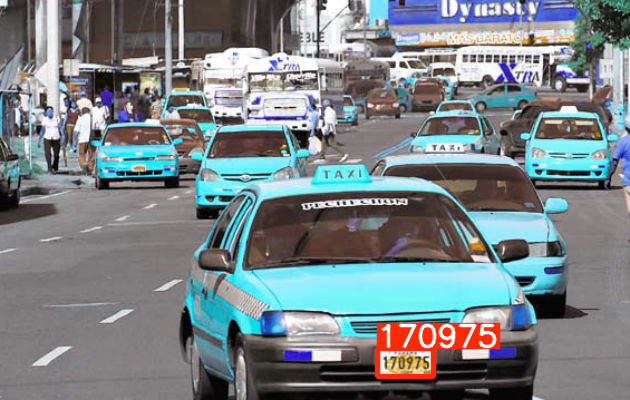

In [34]:
padding = 10  # Adjust the padding value as needed

# Load the single image
im0 = cv2.imread("trafico_panama_2.jpg")
if im0 is None:
    print("Error: Could not load image")
else:
    results = model.predict(im0)[0].boxes
    boxes = results.xyxy.cpu()
    clss = results.cls.cpu()

    ann = Annotator(im0, line_width=3)

    for cls, box in zip(clss, boxes):
        height, width, _ = im0.shape  # Get the dimensions of the original image

        # Calculate padded coordinates
        x1 = max(int(box[0]) - padding, 0)
        y1 = max(int(box[1]) - padding, 0)
        x2 = min(int(box[2]) + padding, width)
        y2 = min(int(box[3]) + padding, height)

        # Crop the object with padding and encode the numpy array to base64 format.
        cropped_img = im0[y1:y2, x1:x2]
        # Ensure the cropped image is not empty before encoding
        if cropped_img.size > 0:
            _, buffer = cv2.imencode(".jpg", cropped_img)
            base64_im0 = base64.b64encode(buffer).decode("utf-8")

            response = extract_text(base64_im0)

            if response:
                print(f"Extracted text: {response}")
                ann.box_label(box, label=str(response), color=colors(cls, True))
            else:
                print("No text extracted.")
                ann.box_label(box, label="No Plate", color=colors(cls, True))
        else:
            print(f"Cropped image is empty for box: {box}")

    # Display the processed image
    # Convert BGR to RGB for displaying in Colab
    im_rgb = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)
    from google.colab.patches import cv2_imshow
    cv2_imshow(im_rgb)

In [27]:
for m in genai.list_models():
  if "generateContent" in m.supported_generation_methods:
    print(m.name)

models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-flash-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5-computer-use-preview-10-2025
models/deep-research-pro-preview-12-2025
